<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Проверка-на-адекватность" data-toc-modified-id="Проверка-на-адекватность-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка на адекватность</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#1.-Предобработка-данных" data-toc-modified-id="1.-Предобработка-данных-5.0.1"><span class="toc-item-num">5.0.1&nbsp;&nbsp;</span>1. Предобработка данных</a></span></li><li><span><a href="#2.-Анализ-данных" data-toc-modified-id="2.-Анализ-данных-5.0.2"><span class="toc-item-num">5.0.2&nbsp;&nbsp;</span>2. Анализ данных</a></span></li><li><span><a href="#3.-Обучение-моделей" data-toc-modified-id="3.-Обучение-моделей-5.0.3"><span class="toc-item-num">5.0.3&nbsp;&nbsp;</span>3. Обучение моделей</a></span></li><li><span><a href="#4.-Выбор-лучшей-модели" data-toc-modified-id="4.-Выбор-лучшей-модели-5.0.4"><span class="toc-item-num">5.0.4&nbsp;&nbsp;</span>4. Выбор лучшей модели</a></span></li><li><span><a href="#5.-Тестирование-лучшей-модели" data-toc-modified-id="5.-Тестирование-лучшей-модели-5.0.5"><span class="toc-item-num">5.0.5&nbsp;&nbsp;</span>5. Тестирование лучшей модели</a></span></li></ul></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Итоговый вывод</a></span></li></ul></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import math

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor

import time

Прочтём данные из файла ```taxi.csv```. Столбец с датой и временем примем за колонку с индексами.

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Познакомимся с данными. Получим общую информацию о датасете, его размерность, проверим наличие дубликатов и пропусков. Посмотрим базовую статистику.

In [3]:
def data_summary(data):
    # Подсчитаем количество пропусков в данных
    missing_values = data.isnull().sum()

    # Подсчитаем количество дубликатов
    duplicates = data.duplicated().sum()

    # Вычислим основные статистические характеристики данных
    statistics = data.describe()

    # Выведем результаты
    print('Общая информация о данных:')
    print(data.info())
    print('Первые 5 строк таблицы:')
    display(data.head(5))
    print('Количество пропусков:')
    print(missing_values)
    print('\nКоличество дубликатов:', duplicates)
    print('\nБазовая статистика:')
    print(statistics)
    
data_summary(data)

Общая информация о данных:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None
Первые 5 строк таблицы:


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Количество пропусков:
num_orders    0
dtype: int64

Количество дубликатов: 26415

Базовая статистика:
         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000


По полученной информации видно:

- Датафрейм состоит из 26496 строк и двух столбцов
- Столбец ```datetime``` с датой и временем мы приняли за индексы
- Второй столбец ```num_orders``` содержит информацию о количестве заказов 
- Шаг временного ряда равен 10 минутам
- В среднем за 10 минут принимается 14 заказов
- Максимальное количество заказов за 10 минут - 119, минимальное - 0

Дубликаты связаны с тем, что в разное время может быть одно и то же количество заказов.

Проверим соблюдение хронологии в столбце индексов```datetime```.

In [4]:
data.index.is_monotonic

True

Хронология соблюдена

Выполним ресэмплирование по промежутку в 1 час.

In [5]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Данные предварительно обработаны, можно переходить к их анализу.

## Анализ

Декомпозируем временной ряд. Декомпозиция временного ряда - это процесс разбиения временного ряда на его компоненты, такие как тренд, сезонность и остатки (шум). Это может помочь в анализе данных, выявлении паттернов и прогнозировании будущих значений. Проведём декомпозицию временного ряда в Python, используя библиотеку ```statsmodels```.

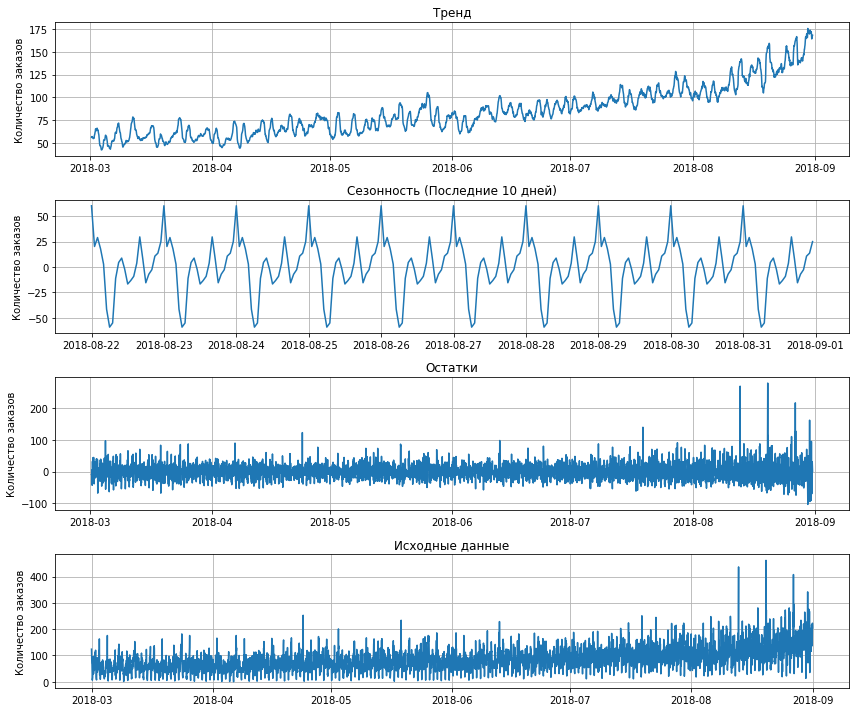

In [6]:
# Декомпозиция временного ряда
decomposition = seasonal_decompose(data['num_orders'])

# Визуализация компонент
plt.figure(figsize=(12, 10))

# График Тренда
plt.subplot(411)
plt.plot(decomposition.trend)
plt.title('Тренд')
plt.ylabel('Количество заказов')
plt.grid(True)

# График Сезонности с данными за последние 10 дней (240 часов)
plt.subplot(412)
plt.plot(decomposition.seasonal.tail(240))
plt.title('Сезонность (Последние 10 дней)')
plt.ylabel('Количество заказов')
plt.grid(True)


# График Остатков
plt.subplot(413)
plt.plot(decomposition.resid)
plt.title('Остатки')
plt.ylabel('Количество заказов')
plt.grid(True)

# График исходных данных
plt.subplot(414)
plt.plot(data['num_orders'])
plt.title('Исходные данные')
plt.ylabel('Количество заказов')
plt.grid(True)

plt.tight_layout()
plt.show()

#### Вывод:
Глядя на графики можно сделать следующие выводы:

- График тренда имеет восходящую тенденцию, следовательно количество заказов такси растёт со временем, а сервис набирает популярность.
- График сезонности показывает, что количество заказов меняется в течение суток с повторяющейся закономерностью: поздней ночью и ранним утром заказов меньше всего, в начале и в конце рабочего дня наблюдаются всплески количества заказов, а к полуночи (когда общественный транспорт перестаёт работать) количество заказов такси достигает максимума.
- Амплитуда шума на графике остатков расширяется вместе с ростом графика тренда. Это может указывать на наличие гетероскедастичности. Гетероскедастичность означает, что дисперсия остатков меняется с течением времени. Это может быть связано с изменением вариабельности данных во времени.

Изучим недельную сезонность. Для этого произведём ресэмплирование по дням и построим график.

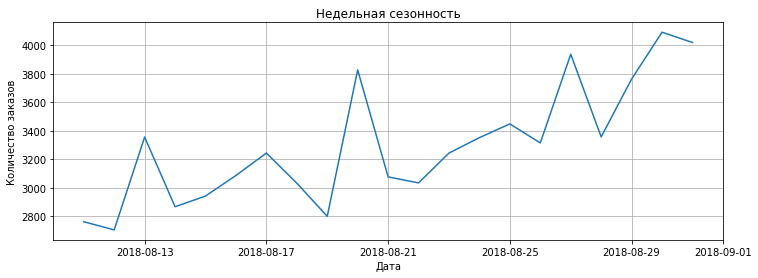

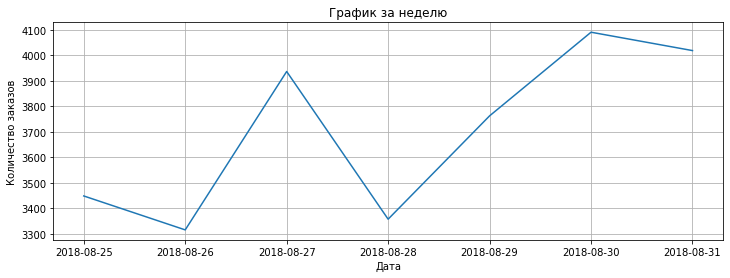

In [7]:
data_daily = data['num_orders'].resample('D').sum()

# График недельной сезонности за последние три недели
plt.figure(figsize=(12, 4))
plt.plot(data_daily[-21:].index, data_daily[-21:].values)
plt.title('Недельная сезонность')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.grid(True)
plt.show()

# График за одну неделю (для изучения тенденций внутри недели)
plt.figure(figsize=(12, 4))
plt.plot(data_daily[-7:].index, data_daily[-7:].values)
plt.title('График за неделю')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.grid(True)
plt.show()

**Вывод:**
На графике видно, что имеет место устойчивый паттерн недельной сезонности. 25 августа 2018 года была суббота. Следовательно, очевидно, что в воскресенье такси заказывают меньше всего, больше всего в понедельник, далее количество заказов растёт к четвергу и снижается к воскресенью.

## Обучение

Приступим к обучению моделей.
Сперва сгенерируем признакии. Нам понадобятся:

- Календарные признаки:

    - Час
    - День недели
    - День месяца

- Лаги:

    - От 1 отстающего до 12
    - 24
    - 48
    - 168
    
- Скользящее среднее

    - С окном 24 (так как имеется дневная сезонность)
    - С окном 168 (так как имеется недельная сезонность)

In [8]:
def make_features(df, max_lag):
    data = df.copy()
    
    # Календарные признаки
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['dayofmonth'] = data.index.day
    
    # Лаги
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    # Отдельные лаги под номерами 24, 48, 168
    data['lag_24'] = data['num_orders'].shift(24)
    data['lag_48'] = data['num_orders'].shift(48)
    data['lag_168'] = data['num_orders'].shift(168)
    
    # Rolling Mean с окнами размером 24 и 168
    data['rolling_mean_24'] = data['num_orders'].shift().rolling(24).mean()
    data['rolling_mean_168'] = data['num_orders'].shift().rolling(168).mean()
    data = data.dropna()

    return data

data = make_features(data, 12)
data.columns

Index(['num_orders', 'hour', 'dayofweek', 'dayofmonth', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10',
       'lag_11', 'lag_12', 'lag_24', 'lag_48', 'lag_168', 'rolling_mean_24',
       'rolling_mean_168'],
      dtype='object')

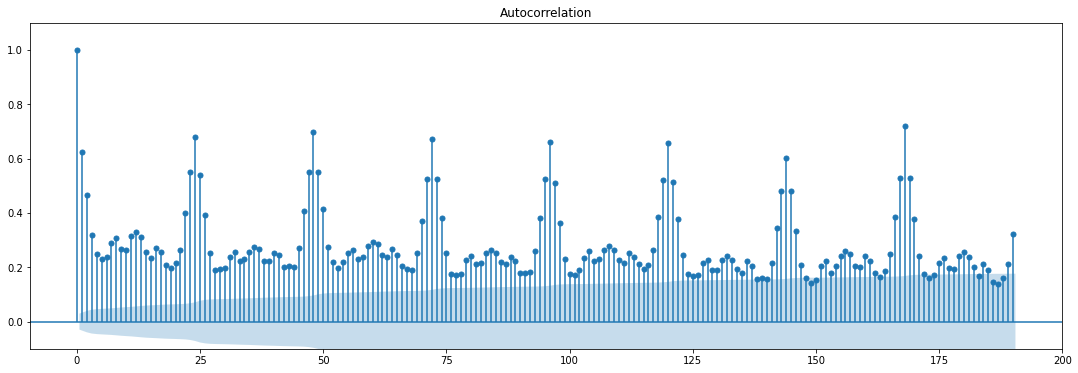

In [9]:
# Код ревьюера
from statsmodels.graphics import tsaplots

taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 


Выделим признаки и целевой признак.

In [10]:
# Выделение признаков и целевого признака
features = data.drop(['num_orders'], axis=1)
target = data['num_orders']

Разделим данные на обучающую и тестовую выборки. Так как будет использоваться кросс-валидация, валидационная выборка не нужна.

In [11]:
# Разделение данных на обучающую и тестовую выборки
data_train, data_test, target_train, target_test = train_test_split(features, target, test_size=0.1, random_state=12345, shuffle=False)

Приступим к обучению моделей и подбору гиперпараметров на кросс-валидации.

In [12]:
tscv = TimeSeriesSplit(n_splits=4)

In [13]:
data

,num_orders,hour,dayofweek,dayofmonth,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_8,lag_9,lag_10,lag_11,lag_12,lag_24,lag_48,lag_168,rolling_mean_24,rolling_mean_168
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,0,3,8,94.0,127.0,108.0,76.0,50.0,99.0,...,46.0,51.0,43.0,55.0,34.0,100.0,42.0,124.0,60.041667,54.226190
2018-03-08 01:00:00,78,1,3,8,143.0,94.0,127.0,108.0,76.0,50.0,...,48.0,46.0,51.0,43.0,55.0,121.0,75.0,85.0,61.833333,54.339286
2018-03-08 02:00:00,65,2,3,8,78.0,143.0,94.0,127.0,108.0,76.0,...,99.0,48.0,46.0,51.0,43.0,24.0,36.0,71.0,60.041667,54.297619
2018-03-08 03:00:00,68,3,3,8,65.0,78.0,143.0,94.0,127.0,108.0,...,50.0,99.0,48.0,46.0,51.0,66.0,49.0,66.0,61.750000,54.261905
2018-03-08 04:00:00,60,4,3,8,68.0,65.0,78.0,143.0,94.0,127.0,...,76.0,50.0,99.0,48.0,46.0,73.0,30.0,43.0,61.833333,54.273810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,4,31,207.0,217.0,197.0,116.0,133.0,166.0,...,167.0,191.0,203.0,182.0,46.0,72.0,169.0,113.0,164.875000,154.297619
2018-08-31 20:00:00,154,20,4,31,136.0,207.0,217.0,197.0,116.0,133.0,...,136.0,167.0,191.0,203.0,182.0,142.0,191.0,179.0,167.541667,154.434524
2018-08-31 21:00:00,159,21,4,31,154.0,136.0,207.0,217.0,197.0,116.0,...,166.0,136.0,167.0,191.0,203.0,198.0,170.0,166.0,168.041667,154.285714


In [14]:
# Модель 1: RandomForestRegressor
param_grid_rf = {
    'n_estimators': [7, 14, 21],
    'max_depth': [None, 5, 10]
}
rf_model = RandomForestRegressor(random_state=12345)
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)

grid_search_rf.fit(data_train, target_train)

best_model_rf = grid_search_rf.best_estimator_
best_params_rf = grid_search_rf.best_params_
rmse_rf = abs(grid_search_rf.best_score_)


# Модель 2: LightGBM
param_grid_lgbm = {
    'num_leaves': [15, 30, 45],
    'learning_rate': [0.01, 0.1, 0.2]
}
lgbm_model = LGBMRegressor(objective='regression', metric='rmse')
grid_search_lgbm = GridSearchCV(estimator=lgbm_model, param_grid=param_grid_lgbm, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)

grid_search_lgbm.fit(data_train, target_train)

best_model_lgbm = grid_search_lgbm.best_estimator_
best_params_lgbm = grid_search_lgbm.best_params_
rmse_lgbm = abs(grid_search_lgbm.best_score_)

# Модель 3: DecisionTreeRegressor
param_grid_dtr = {
    'max_depth': [None, 4, 8],
    'min_samples_leaf': [1, 2, 4]
}
dtr_model = DecisionTreeRegressor()
grid_search_dtr = GridSearchCV(estimator=dtr_model, param_grid=param_grid_dtr, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)

grid_search_dtr.fit(data_train, target_train)

rmse_dtr = abs(grid_search_dtr.best_score_)

# Оценка времени работы моделей на тренировочной выборке
start_time = time.time()
best_model_rf.fit(data_train, target_train)
training_time_rf = time.time() - start_time
predict_start_time = time.time()
predictions_rf = best_model_rf.predict(data_train)
predict_time_rf = time.time() - predict_start_time

start_time = time.time()
best_model_lgbm.fit(data_train, target_train)
training_time_lgbm = time.time() - start_time
predict_start_time = time.time()
predictions_lgbm = best_model_lgbm.predict(data_train)
predict_time_lgbm = time.time() - predict_start_time

start_time = time.time()
dtr_model.fit(data_train, target_train)
training_time_dtr = time.time() - start_time
predict_start_time = time.time()
predictions_dtr = dtr_model.predict(data_train)
predict_time_dtr = time.time() - predict_start_time


# Вывод результатов
print("Лучшие параметры RandomForestRegressor:", best_params_rf)
print(f"RMSE RandomForestRegressor на кросс-валидации: {rmse_rf:.2f}")
print(f"Время обучения RandomForestRegressor: {training_time_rf:.2f} секунд")
print(f"Время предсказания RandomForestRegressor: {predict_time_rf:.2f} секунд")
print()
print('_'*30)
print()
print("Лучшие параметры LightGBM:", best_params_lgbm)
print(f"RMSE LightGBM на кросс-валидации: {rmse_lgbm:.2f}")
print(f"Время обучения LightGBM: {training_time_lgbm:.2f} секунд")
print(f"Время предсказания LightGBM: {predict_time_lgbm:.2f} секунд")
print()
print('_'*30)
print()
print(f"RMSE DecisionTreeRegressor на кросс-валидации: {rmse_dtr:.2f}")
print(f"Время обучения DecisionTreeRegressor: {training_time_dtr:.2f} секунд")
print(f"Время предсказания DecisionTreeRegressor: {predict_time_dtr:.2f} секунд")
print()
print('='*30)
print()
# Выбор лучшей модели
best_model = None
best_model_name = None
best_rmse = float('inf')

if rmse_rf < best_rmse:
    best_model = best_model_rf
    best_model_name = "RandomForestRegressor"
    best_rmse = rmse_rf

if rmse_lgbm < best_rmse:
    best_model = best_model_lgbm
    best_model_name = "LightGBM"
    best_rmse = rmse_lgbm

if rmse_dtr < best_rmse:
    best_model = dtr_model
    best_model_name = "DecisionTreeRegressor"
    best_rmse = rmse_dtr

# Предсказание и измерение времени предсказания на тестовой выборке
predict_start_time = time.time()
test_predictions = best_model.predict(data_test)
predict_time_test = time.time() - predict_start_time

# Рассчёт RMSE на тестовой выборке
test_rmse = math.sqrt(mean_squared_error(target_test, test_predictions))

# Вывод результатов на тестовой выборке

print(f"Лучшая модель: {best_model_name}")
print(f"RMSE лучшей модели ({best_model_name}) на тестовой выборке: {test_rmse:.2f}")
print(f"Время предсказания лучшей модели ({best_model_name}) на тестовой выборке: {predict_time_test:.2f} секунд")

Лучшие параметры RandomForestRegressor: {'max_depth': None, 'n_estimators': 21}
RMSE RandomForestRegressor на кросс-валидации: 23.68
Время обучения RandomForestRegressor: 0.77 секунд
Время предсказания RandomForestRegressor: 0.02 секунд

______________________________

Лучшие параметры LightGBM: {'learning_rate': 0.1, 'num_leaves': 15}
RMSE LightGBM на кросс-валидации: 23.49
Время обучения LightGBM: 33.41 секунд
Время предсказания LightGBM: 0.09 секунд

______________________________

RMSE DecisionTreeRegressor на кросс-валидации: 26.48
Время обучения DecisionTreeRegressor: 0.13 секунд
Время предсказания DecisionTreeRegressor: 0.00 секунд


Лучшая модель: LightGBM
RMSE лучшей модели (LightGBM) на тестовой выборке: 38.20
Время предсказания лучшей модели (LightGBM) на тестовой выборке: 0.00 секунд


## Проверка на адекватность

In [15]:
# Создание прогноза предыдущим значением
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

# Рассчет RMSE для прогноза предыдущим значением
rmse_previous = math.sqrt(mean_squared_error(target_test, pred_previous))

# Вывод RMSE для прогноза предыдущим значением
print(f"RMSE для прогноза предыдущим значением: {rmse_previous:.2f}")


RMSE для прогноза предыдущим значением: 58.82


RMSE dummy-модели хуже, следовательно наша модель адекватна.

## Общий вывод

В ходе выполнения проекта были выполнены следующие этапы:

#### 1. Предобработка данных
- Проведено ресемплирование данных по одному часу.
- Созданы дополнительные признаки:

#### 2. Анализ данных
- Произведен анализ временных рядов, который выявил следующие закономерности:
  - Наблюдается восходящая тенденция на графике тренда, что указывает на увеличение заказов такси со временем. Однако, важно понимать, что поскольку у нас нет данных за несколько лет, мы не можем с точностью утверждать, что эта тенденция не связана с годовой сезонностью. Рост показателей к августу может быть связан с сезоном отпусков.
  - График сезонности показал изменения количества заказов в течение суток с повторяющейся закономерностью.
  - Амплитуда шума на графике остатков расширяется вместе с ростом графика тренда, что может указывать на наличие гетероскедастичности данных.
  - Также на графике сезонности при ресэмплировании по дням видно, что имеет место устойчивый паттерн недельной сезонности. 25 августа 2018 года была суббота. Следовательно, очевидно, что в воскресенье такси заказывают меньше всего, больше всего в понедельник, далее количество заказов растёт к четвергу и снижается к воскресенью.
#### 3. Обучение моделей
- Были обучены три различные модели прогнозирования: решающее дерево, случайный лес и градиентный бустинг.
- Для каждой модели проведен подбор оптимальных гиперпараметров с использованием GridSearchCV.

#### 4. Выбор лучшей модели
- Наилучшие результаты были достигнуты с использованием модели LightGBM с оптимальными гиперпараметрами: learning_rate=0.1 и num_leaves=15.
- RMSE модели LightGBM на кросс-валидации составил 23.49.

#### 5. Тестирование лучшей модели
- Лучшая модель LightGBM была протестирована на тестовой выборке, и RMSE на ней составил 38.20.

### Итоговый вывод
Проект проведен успешно, и была разработана модель прогнозирования количества заказов такси на следующий час. Лучшей моделью оказалась LightGBM с настроенными гиперпараметрами ```learning_rate=0.1``` и ```num_leaves=15```, и её производительность была успешно проверена на тестовой выборке. Модель позволяет прогнозировать количество заказов с высокой точностью, что полезно для оптимизации работы такси-сервиса и улучшения качества обслуживания клиентов.